In [2]:
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection.search import GridSearchCV, RandomizedSearchCV
from surprise.model_selection.split import train_test_split
from train_valid_test_loader import load_train_valid_test_datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


In [3]:
train_tuple, valid_tuple, test_tuple, n_users, n_items = \
    load_train_valid_test_datasets()
DATA_PATH = 'data_movie_lens_100k/'
reader = Reader(
    line_format='user item rating', sep=',',
    rating_scale=(1, 5), skip_lines=1)

[    0     1     2 ... 89989 89990 89991]


In [4]:
df_training = pd.read_csv(DATA_PATH + 'ratings_all_development_set.csv')
total_dataset = Dataset.load_from_df(df_training, reader=reader)
training = total_dataset.build_full_trainset()
training_split, validation_split = train_test_split(total_dataset, random_state=124323)

In [6]:
parameter_grid = dict()
parameter_grid['random_state'] = {123453}
parameter_grid['n_epochs'] = {20, 60, 100, 150, 200, 250, 300, 350, 400}
parameter_grid['n_factors'] = {2, 10, 25, 50}
parameter_grid['lr_all'] = np.logspace(-4, 4, 9)
parameter_grid['reg_all'] = np.logspace(-4, 4, 9)
grid_searcher = RandomizedSearchCV(
    SVD,
    parameter_grid,
    n_iter=25,
    measures=['mae'],
    #cv=splitter,
    refit=True,
    joblib_verbose=50
)
grid_searcher.fit(total_dataset)


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   11.5s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   22.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   33.7s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   44.3s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   54.9s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:   59.7s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:  2.1min
[Parallel(n_jobs=1)]: Do

In [49]:
training_results = grid_searcher.best_estimator['mae'].test(training.build_testset())
training_ratings = [predict.r_ui for predict in training_results]
init_mean = np.mean(training_ratings)

In [37]:
grid_searcher.best_params

{'mae': {'random_state': 123453,
  'n_epochs': 350,
  'n_factors': 2,
  'lr_all': 0.01,
  'reg_all': 0.1}}

In [65]:
K_vals = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
lr_all = np.logspace(-4, 4, 9)
MAE_valid = []
MAE_train = []
for lr in lr_all:
    k_test_model = SVD(n_factors=2, n_epochs=350, lr_all=lr, reg_all=0.1, random_state=123453)    
    k_test_model.fit(training_split)
    results_valid = k_test_model.test(validation_split)
    results_train = k_test_model.test(training_split.build_testset())
    MAE_valid.append(accuracy.mae(results_valid))
    MAE_train.append(accuracy.mae(results_train))

MAE:  0.7627
MAE:  0.7398
MAE:  0.7367
MAE:  0.6933
MAE:  0.7317
MAE:  0.6639
MAE:  0.7693
MAE:  0.7074
MAE:  1.4707
MAE:  1.4705
MAE:  1.4707
MAE:  1.4705
MAE:  1.4707
MAE:  1.4705
MAE:  1.4707
MAE:  1.4705
MAE:  1.4707
MAE:  1.4705


Text(0.5, 1.0, 'MAE across Learning Rate Values')

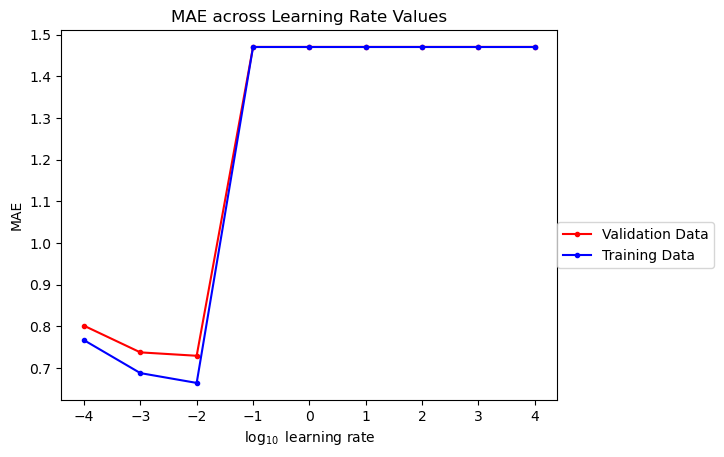

In [51]:
plt.plot(np.log10(lr_all), MAE_valid, '.-', color='red', label='Validation Data')
plt.plot(np.log10(lr_all), MAE_train, '.-', color='blue', label='Training Data')
plt.ylabel("MAE")
plt.legend(bbox_to_anchor=(1.33, 0.5))
plt.xlabel("$\log_{10}$ learning rate")
plt.title("MAE across Learning Rate Values")

In [66]:
K_vals = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
MAE_valid = []
MAE_train = []
for K in K_vals:
    k_test_model = SVD(n_factors=K, n_epochs=350, lr_all=0.01, reg_all=0.1, random_state=123453)    
    k_test_model.fit(training_split)
    results_valid = k_test_model.test(validation_split)
    results_train = k_test_model.test(training_split.build_testset())
    MAE_valid.append(accuracy.mae(results_valid))
    MAE_train.append(accuracy.mae(results_train))

MAE:  0.7317
MAE:  0.6639
MAE:  0.7304
MAE:  0.6158
MAE:  0.7331
MAE:  0.5658
MAE:  0.7314
MAE:  0.5330
MAE:  0.7321
MAE:  0.5107
MAE:  0.7337
MAE:  0.4946
MAE:  0.7315
MAE:  0.4834
MAE:  0.7313
MAE:  0.4748
MAE:  0.7310
MAE:  0.4690
MAE:  0.7314
MAE:  0.4644
MAE:  0.7296
MAE:  0.4611
MAE:  0.7299
MAE:  0.4589


Text(0.5, 1.0, 'MAE across K Values')

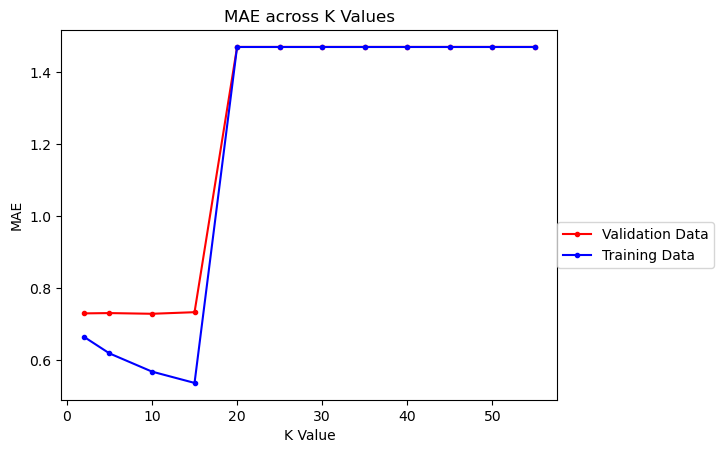

In [53]:
plt.plot(K_vals, MAE_valid, '.-', color='red', label='Validation Data')
plt.plot(K_vals, MAE_train, '.-', color='blue', label='Training Data')
plt.ylabel("MAE")
plt.legend(bbox_to_anchor=(1.33, 0.5))
plt.xlabel("K Value")
plt.title("MAE across K Values")

In [67]:
reg_all = np.logspace(-4, 4, 9)
MAE_valid = []
MAE_train = []
for reg in reg_all:
    k_test_model = SVD(n_factors=2, n_epochs=350, lr_all=0.01, reg_all=reg, random_state=123453)    
    k_test_model.fit(training_split)
    results_valid = k_test_model.test(validation_split)
    results_train = k_test_model.test(training_split.build_testset())
    MAE_valid.append(accuracy.mae(results_valid))
    MAE_train.append(accuracy.mae(results_train))

MAE:  0.7357
MAE:  0.6381
MAE:  0.7356
MAE:  0.6383
MAE:  0.7339
MAE:  0.6400
MAE:  0.7317
MAE:  0.6639
MAE:  0.8084
MAE:  0.7861
MAE:  0.9223
MAE:  0.9120
MAE:  0.9473
MAE:  0.9400
MAE:  1.4707
MAE:  1.4705
MAE:  1.4707
MAE:  1.4705


Text(0.5, 1.0, 'MAE across Regularization Term')

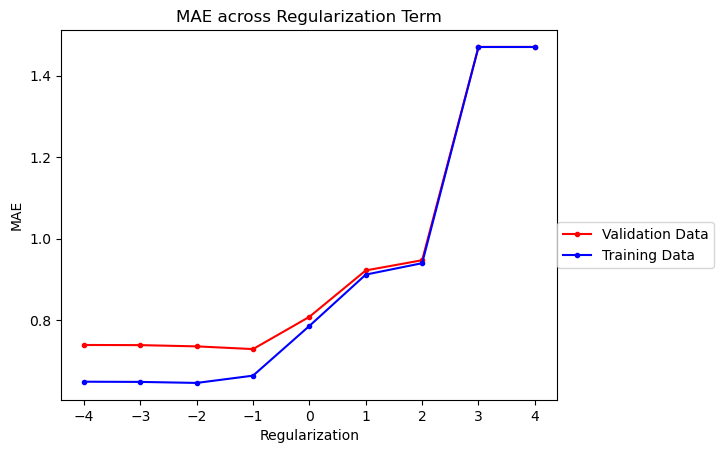

In [57]:
plt.plot(np.log10(reg_all), MAE_valid, '.-', color='red', label='Validation Data')
plt.plot(np.log10(reg_all), MAE_train, '.-', color='blue', label='Training Data')
plt.ylabel("MAE")
plt.legend(bbox_to_anchor=(1.33, 0.5))
plt.xlabel("Regularization")
plt.title("MAE across Regularization Term")

In [77]:
true_val = [result.r_ui for result in results_valid]
pred_val = [result.est for result in results_valid]
print(results_valid)

[Prediction(uid=576, iid=383, r_ui=5.0, est=5, details={'was_impossible': False}), Prediction(uid=116, iid=421, r_ui=4.0, est=5, details={'was_impossible': False}), Prediction(uid=325, iid=564, r_ui=4.0, est=5, details={'was_impossible': False}), Prediction(uid=560, iid=662, r_ui=4.0, est=5, details={'was_impossible': False}), Prediction(uid=213, iid=344, r_ui=3.0, est=5, details={'was_impossible': False}), Prediction(uid=698, iid=323, r_ui=5.0, est=5, details={'was_impossible': False}), Prediction(uid=521, iid=207, r_ui=5.0, est=5, details={'was_impossible': False}), Prediction(uid=412, iid=325, r_ui=3.0, est=5, details={'was_impossible': False}), Prediction(uid=918, iid=685, r_ui=1.0, est=5, details={'was_impossible': False}), Prediction(uid=886, iid=391, r_ui=4.0, est=5, details={'was_impossible': False}), Prediction(uid=679, iid=14, r_ui=3.0, est=5, details={'was_impossible': False}), Prediction(uid=201, iid=513, r_ui=1.0, est=5, details={'was_impossible': False}), Prediction(uid=2

Text(0.5, 1.0, 'Predicted vs True')

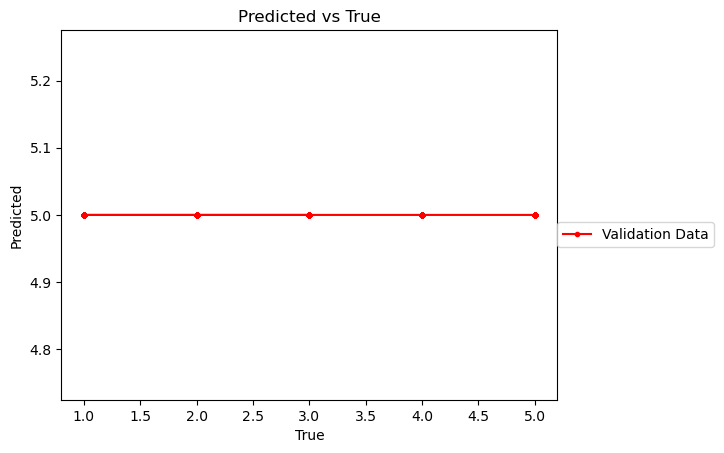

In [74]:
plt.plot(true_val, pred_val, '.-', color='red', label='Validation Data')
plt.ylabel("Predicted")
plt.legend(bbox_to_anchor=(1.33, 0.5))
plt.xlabel("True")
plt.title("Predicted vs True")

In [58]:
df_test = pd.read_csv(DATA_PATH + 'ratings_masked_leaderboard_set.csv')
test_set = Dataset.load_from_df(df_test, reader=reader)
test = test_set.build_full_trainset().build_testset()
print(test)

[(503, 204, nan), (503, 771, nan), (503, 121, nan), (503, 24, nan), (503, 116, nan), (503, 412, nan), (503, 138, nan), (503, 400, nan), (503, 544, nan), (503, 1134, nan), (503, 140, nan), (503, 1044, nan), (503, 199, nan), (503, 497, nan), (503, 844, nan), (503, 665, nan), (503, 8, nan), (503, 384, nan), (503, 415, nan), (503, 721, nan), (503, 368, nan), (503, 1442, nan), (503, 182, nan), (503, 150, nan), (503, 421, nan), (503, 932, nan), (503, 610, nan), (503, 184, nan), (503, 4, nan), (503, 64, nan), (503, 1039, nan), (503, 68, nan), (795, 185, nan), (795, 212, nan), (795, 217, nan), (795, 1030, nan), (795, 515, nan), (795, 99, nan), (795, 926, nan), (795, 427, nan), (795, 878, nan), (795, 793, nan), (795, 1010, nan), (795, 268, nan), (795, 538, nan), (795, 626, nan), (795, 663, nan), (795, 432, nan), (795, 154, nan), (795, 448, nan), (795, 81, nan), (795, 232, nan), (795, 53, nan), (795, 63, nan), (795, 589, nan), (795, 230, nan), (795, 746, nan), (795, 76, nan), (795, 86, nan), (79

In [79]:
svd = SVD(n_factors=10, n_epochs=60, lr_all=0.01, reg_all=0.1, random_state=123453)
svd.fit(training_split)

In [85]:
results_valid = svd.test(validation_split)
true_val = [result.r_ui for result in results_valid]
pred_val = [result.est for result in results_valid]
print(pred_val)
print(results_valid)

[4.00655090407029, 4.2538237682390685, 3.3551495705827525, 3.428110569918867, 4.080325567052595, 2.729215701347685, 3.7310943010385587, 3.266208935476025, 2.9268096821769674, 3.3862217760030617, 3.714828559573069, 3.1568660557295902, 3.9718536629496994, 4.363396906522479, 3.442239419857378, 2.3869538014671132, 3.811034129241194, 4.250017062912536, 3.881498311813968, 3.379257215577961, 2.9810281128446974, 4.373314475563047, 3.929341726639441, 2.8230834605396677, 2.9331712744588305, 3.1558099350554234, 2.7078474573640223, 4.174533838916796, 3.4918009704693755, 4.033364637661775, 3.441819163660079, 2.2609841771952883, 2.703876333317083, 3.2280559139432015, 4.548467045753159, 3.127192500918389, 2.8316679484420595, 3.9318969192324973, 3.976649104755376, 3.56469800095865, 3.781873717896992, 3.515485393214515, 3.778361394831641, 3.5024444016532565, 4.1057019574550875, 2.5186277142914197, 3.872748093509115, 3.3722784108863033, 3.829005863454703, 3.9457125483907407, 2.7609769609219748, 3.413869

Text(0.5, 1.0, 'Predicted vs True')

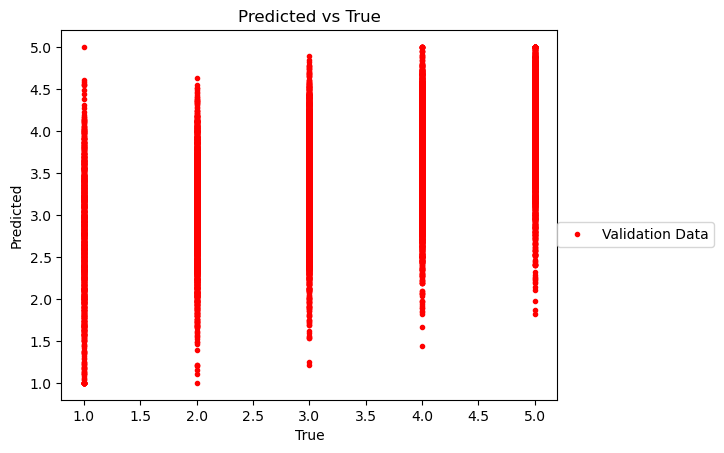

In [83]:
plt.plot(true_val, pred_val, '.', color='red', label='Validation Data')
plt.ylabel("Predicted")
plt.legend(bbox_to_anchor=(1.33, 0.5))
plt.xlabel("True")
plt.title("Predicted vs True")

In [54]:
print(svd.trainset.global_mean)

3.529480398257623


In [60]:
test_results = svd.test(test)
estimated_scores = [result.est for result in test_results]

In [61]:
def write_to_file(results, name="predicted_ratings_leaderboard.txt"):
        with open(name, 'w') as file:
            for item in results:
                file.writelines(str(item) + "\n")

In [64]:
write_to_file(estimated_scores)